# Multi-Telescope Configuration

## Telescope Groups

The 32 telescopes are arranged in 4 groups of 8 telescopes:
- all 8 cameras of each group have exactly the same field-of-view</li>
- the lines-of-sight of the 4 groups are offset by an angle of 9.2° from the PLM +Z axis</li>

<img src="telescopeGroups.png">

→ per group:

- same tilt & azimuth angle
- all telescopes within the same group will observe the target with the same CCD

## Tilt & Azimuth Angle

<img src="tiltAzimuth.png">

## Resulting FOV Configuration

<img src="fov.png">

# Scripting Multi-Telescope Configuration in Python

In [102]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

## Where is my stuff located?

In [103]:
import os
baseDir = os.getenv("PLATO_PROJECT_HOME")
workDir = os.getenv("PLATO_WORKDIR")
print workDir
print baseDir

import sys
sys.path.append(baseDir + "/python")

/Users/sara/work/Instrumentation/Plato/softwareDevelopment/PlatoSim3/docs/tutorials/multiTelescopeConfiguration
/Users/sara/work/Instrumentation/Plato/softwareDevelopment/PlatoSim3


## Importing

In [104]:
import os
import math
from simulation import Simulation
from referenceFrames import getCCDandPixelCoordinates
from referenceFrames import platformToTelescopePointingCoordinates
from referenceFrames import drawCCDsInSky
from referenceFrames import CCD

## Where to find the input parameters and where to store the output?

In [105]:
inputDir = baseDir + "/inputfiles"
inputFile   = inputDir + "/inputfile.yaml"

outputDir   = workDir
outputPrefix = "MultiTelescopeConfiguration"

## Configuration Parameters

### Observing Parameters

In [106]:
raPointing = 180.0                      # Platform right ascension pointing coordinate [degrees]
decPointing = -70.0                     # Platform declination pointing coordinate [degrees]

raCenter = 180.0#227.747586623                # Right ascension on which to centre the sub-field [degrees]
decCenter = -70.0#-63.9874188222              # Declination on which to centre the sub-field [degrees]

numTelescopeGroups = 4                  # Number of telescope groups
numTelescopesPerGroup = 8               # Number of telescopes per group

### Telescope Parameters

In [107]:
azimuthAngles = [45, 135, -135, -45]    # Azimuth angles of the telescopes (same within a group) [degrees]
tiltAngle = 9.2                         # Tilt angle of the telescopes (same for the 4 groups) [degrees]

driftSeed = 1433429158                  # Random seed for telescope drift (different for each telescope!)

### CCD Parameters (different for each telescope)

In [108]:
readoutNoiseSeed =  1424949740          # Random seed for the readout noise
photonNoiseSeed = 1433320336            # Random seed for the photon noise
flatfieldSeed = 1433320381              # Random seed for the flatfield
cteSeed = 1424949740                    # Random seed for the CTE

### Sub-Field Parameters

In [109]:
numColumnsSubField = 10                 # Number of columns in the modelled sub-field [pixels]
numRowsSubField = 10                    # Number of rows in the modelled sub-field [pixels]

## Simulations

For each telescope in each group:
- platform pointing & (tilt, azimuth) -> telescope pointing
- which CCD selected?
- sub-field falls entirely on selected CCD -> simulation


In [111]:
raTelescopePointings = []
decTelescopePointings = []

# Loop over all groups of telescopes

for group in range(numTelescopeGroups):
    
    # Loop over all telescopes in the current group
    
    for telescope in range(numTelescopesPerGroup):
        
        print "Processing telescope " + str(telescope + 1) + " of group " + str(group + 1)
        
        telescopeIndex = numTelescopesPerGroup * group + telescope
        
        # Output will be stored in multiTelescopeConfiguration_group<group>_telescope<telescope>
        
        outputFilePrefix = outputPrefix + "_group" +  "{0:02d}".format(group + 1) + "_telescope" + "{0:02d}".format(telescope + 1)
        sim = Simulation(outputFilePrefix, inputFile)
        sim.outputDir = outputDir
        
        # Compute the telescope pointing, based on the platform pointing, and the tilt and azimuth angle of the telescope
        
        raTelescope, decTelescope = platformToTelescopePointingCoordinates(math.radians(raPointing), math.radians(decPointing), math.radians(azimuthAngles[group]), math.radians(tiltAngle))
        raTelescopePointings.append(math.degrees(raTelescope))
        decTelescopePointings.append(math.degrees(decTelescope))
        
        print "Platform pointing: " + str(raPointing) + ", " + str(decPointing)
        print "Telescope pointing: " + str(math.degrees(raTelescope)) + ", " + str(math.degrees(decTelescope))
        
        includeFieldDistortion = (sim["Camera/IncludeFieldDistortion"] == "yes")        # Whether or not to include field distortion
        focalPlaneAngle = sim["Camera/FocalPlaneOrientation"]                           # Focal-plane orientation [degrees]
        focalLength = sim["Camera/FocalLength"] * 1000                                  # Focal length [mm]
        plateScale = sim["Camera/PlateScale"]                                           # Plate scale [arcsec / micron]
        pixelSize = sim["CCD/PixelSize"]                                                # Pixel size [micron / pixel]
        
        # Determine on which CCD (A, B, C, or D) the coordinates (raCenter, decCenter) are positioned and at which location
        # (in pixel coordinates)
        
        ccdCode, columnCenter, rowCenter = getCCDandPixelCoordinates(math.radians(raCenter), math.radians(decCenter), raTelescope, decTelescope, math.radians(focalPlaneAngle), focalLength, plateScale, pixelSize, includeFieldDistortion, nominal=True)
        
        # Check whether the sub-field falls entirely on the detector
        
        if (ccdCode != None) and (rowCenter - numRowsSubField / 2 >= 0) and (rowCenter + numRowsSubField / 2 < CCD[ccdCode]["Nrows"]) and (columnCenter - numColumnsSubField / 2 >= 0) and (columnCenter + numColumnsSubField / 2 < CCD[ccdCode]["Ncols"]):
            
            print "CCD " + ccdCode + " selected"
            
            # Observing parameters
        
            sim["ObservingParameters/RApointing"] = raPointing
            sim["ObservingParameters/DecPointing"] = decPointing
        
            # Telescope parameters
                        
            sim["Telescope/AzimuthAngle"] = azimuthAngles[group]
            sim["Telescope/TiltAngle"] = tiltAngle
    
            # CCD parameters
        
            sim["CCD/OriginOffsetX"] = CCD[ccdCode]["zeroPointXmm"]
            sim["CCD/OriginOffsetY"] = CCD[ccdCode]["zeroPointYmm"]
            sim["CCD/Orientation"] = CCD[ccdCode]["angle"]
            sim["CCD/NumColumns"] = CCD[ccdCode]["Ncols"]
            sim["CCD/NumRows"] = CCD[ccdCode]["Nrows"]
            
            # Sub-field parameters
        
            sim["SubField/ZeroPointRow"] = int(rowCenter - numRowsSubField / 2)
            sim["SubField/ZeroPointColumn"] = int(columnCenter - numColumnsSubField / 2)
        
            sim["SubField/NumColumns"] = numColumnsSubField
            sim["SubField/NumRows"] = numRowsSubField
        
            # Seed parameters
        
            sim["RandomSeeds/ReadOutNoiseSeed"] = readoutNoiseSeed + telescopeIndex
            sim["RandomSeeds/PhotonNoiseSeed"] = photonNoiseSeed + telescopeIndex
            sim["RandomSeeds/FlatFieldSeed"] = flatfieldSeed + telescopeIndex 
            sim["RandomSeeds/CTESeed"] = cteSeed + telescopeIndex 
            sim["RandomSeeds/DriftSeed"] = driftSeed + telescopeIndex  
        
            sim.run()
            
        else:
            print "Sub-field centred on (" + str(raCenter) + ", " + str(decCenter) + ") does not lay entirely on a CCD for telescope " + str(telescope + 1) + " of group " + str(group + 1)

Processing telescope 1 of group 1
Platform pointing: 180.0, -70.0
Telescope pointing: 206.039772912, -75.0766240288
CCD C selected
Processing telescope 2 of group 1
Platform pointing: 180.0, -70.0
Telescope pointing: 206.039772912, -75.0766240288
CCD C selected
Processing telescope 3 of group 1
Platform pointing: 180.0, -70.0
Telescope pointing: 206.039772912, -75.0766240288
CCD C selected
Processing telescope 4 of group 1
Platform pointing: 180.0, -70.0
Telescope pointing: 206.039772912, -75.0766240288
CCD C selected
Processing telescope 5 of group 1
Platform pointing: 180.0, -70.0
Telescope pointing: 206.039772912, -75.0766240288
CCD C selected
Processing telescope 6 of group 1
Platform pointing: 180.0, -70.0
Telescope pointing: 206.039772912, -75.0766240288
CCD C selected
Processing telescope 7 of group 1
Platform pointing: 180.0, -70.0
Telescope pointing: 206.039772912, -75.0766240288
CCD C selected
Processing telescope 8 of group 1
Platform pointing: 180.0, -70.0
Telescope pointin

## Inspecting the Output

### Platform Pointing vs. Telescope Pointing

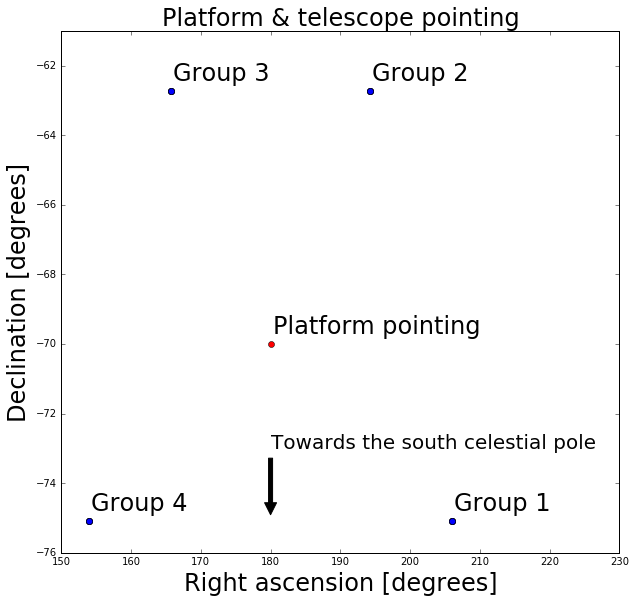

In [151]:
# Layout

fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Platform & telescope pointing', fontsize = 24)
ax.set_xlabel('Right ascension [degrees]', fontsize = 24)
ax.set_ylabel('Declination [degrees]', fontsize = 24)
ax.axis([150, 230, -76, -61])

ax.annotate('Towards the south celestial pole', xy = (180, -75), xytext=(180, -73),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 20)

offsetX = 0.3
offsetY = 0.3

# Platform pointing

ax.plot([raPointing], [decPointing], "ro")
ax.text(raPointing + offsetX, decPointing + offsetY, r'Platform pointing', fontsize=24)

# Telescope pointing

ax.plot(raTelescopePointings, decTelescopePointings, "bo")

for index in range(numTelescopeGroups):
   ax.text(raTelescopePointings[index * numTelescopesPerGroup] + offsetX, decTelescopePointings[index * numTelescopesPerGroup] + offsetY, "Group " + str(index + 1), fontsize = 24)

### Which CCD was Selected by which Telescope (Group)?

#### Telescope group 1: CCD C selected

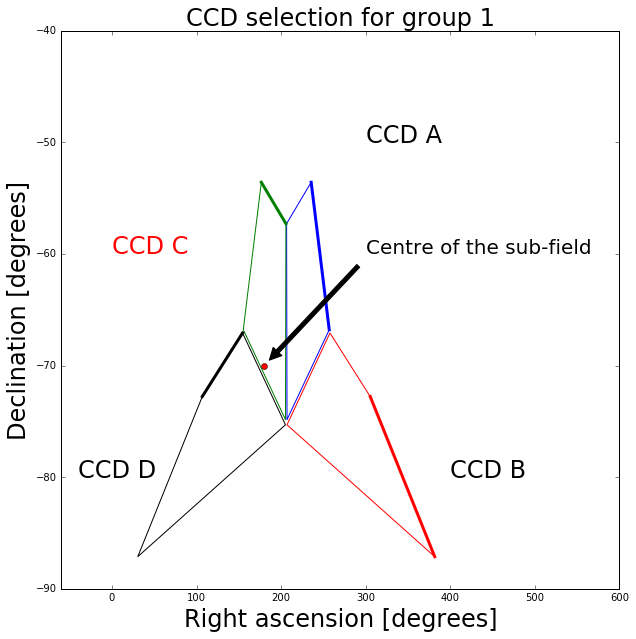

In [152]:
drawCCDsInSky(math.radians(raTelescopePointings[0]), math.radians(decTelescopePointings[0]), 0.0, 0.24712595 * 1000, 18)

plt.title('CCD selection for group 1', fontsize = 24)
plt.xlabel('Right ascension [degrees]', fontsize = 24)
plt.ylabel('Declination [degrees]', fontsize = 24)
plt.axis([-60, 600, -90, -40])

plt.plot([raCenter], [decCenter], "ro")

plt.annotate('Centre of the sub-field', xy = (raCenter, decCenter), xytext=(300, -60),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 20)

plt.text(300, -50, 'CCD A', fontsize=24)
plt.text(400, -80, 'CCD B', fontsize=24)
plt.text(0, -60, 'CCD C', fontsize=24, color = 'r')
plt.text(-40, -80, 'CCD D', fontsize=24)

#### Telescope group 2: CCD D selected

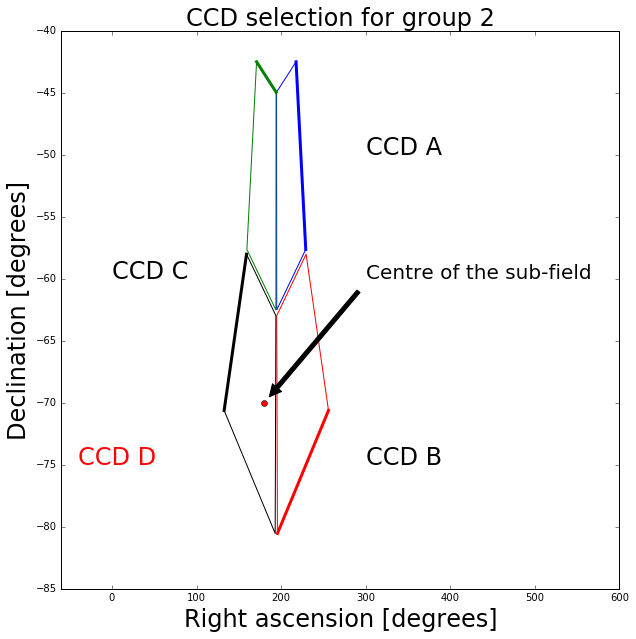

In [153]:
drawCCDsInSky(math.radians(raTelescopePointings[numTelescopesPerGroup]), math.radians(decTelescopePointings[numTelescopesPerGroup]), 0.0, 0.24712595 * 1000, 18)

plt.title('CCD selection for group 2', fontsize = 24)
plt.xlabel('Right ascension [degrees]', fontsize = 24)
plt.ylabel('Declination [degrees]', fontsize = 24)
plt.axis([-60, 600, -85, -40])

plt.plot([raCenter], [decCenter], "ro")

plt.annotate('Centre of the sub-field', xy = (raCenter, decCenter), xytext=(300, -60),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 20)

plt.text(300, -50, 'CCD A', fontsize=24)
plt.text(300, -75, 'CCD B', fontsize=24)
plt.text(0, -60, 'CCD C', fontsize=24)
plt.text(-40, -75, 'CCD D', fontsize=24, color = 'r')

#### Telescope group 3: CCD B selected

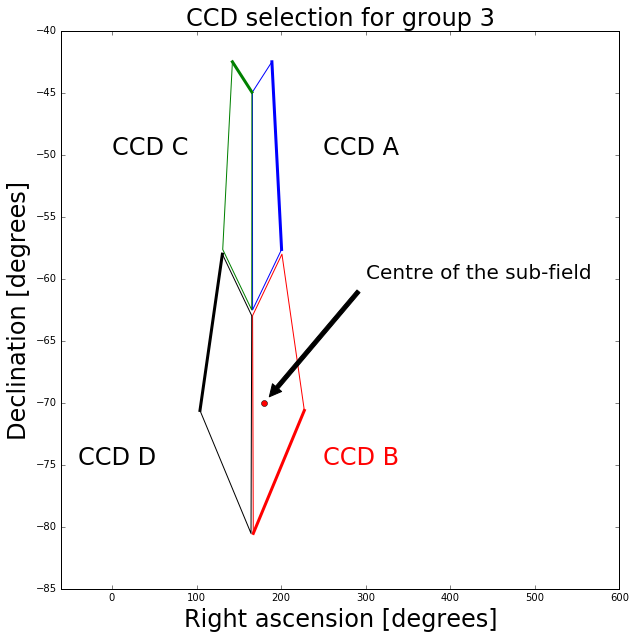

In [154]:
drawCCDsInSky(math.radians(raTelescopePointings[2 * numTelescopesPerGroup]), math.radians(decTelescopePointings[2 * numTelescopesPerGroup]), 0.0, 0.24712595 * 1000, 18)

plt.title('CCD selection for group 3', fontsize = 24)
plt.xlabel('Right ascension [degrees]', fontsize = 24)
plt.ylabel('Declination [degrees]', fontsize = 24)
plt.axis([-60, 600, -85, -40])

plt.plot([raCenter], [decCenter], "ro")

plt.annotate('Centre of the sub-field', xy = (raCenter, decCenter), xytext=(300, -60),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 20)

plt.text(250, -50, 'CCD A', fontsize=24)
plt.text(250, -75, 'CCD B', fontsize=24, color = 'r')
plt.text(0, -50, 'CCD C', fontsize=24)
plt.text(-40, -75, 'CCD D', fontsize=24)

#### Telescope group 4: CCD A selected

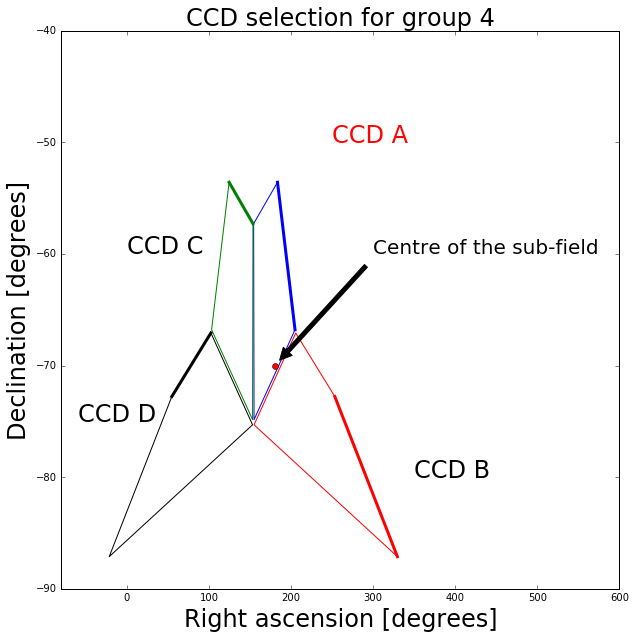

In [155]:
drawCCDsInSky(math.radians(raTelescopePointings[3 * numTelescopesPerGroup]), math.radians(decTelescopePointings[3 * numTelescopesPerGroup]), 0.0, 0.24712595 * 1000, 18)

plt.title('CCD selection for group 4', fontsize = 24)
plt.xlabel('Right ascension [degrees]', fontsize = 24)
plt.ylabel('Declination [degrees]', fontsize = 24)
plt.axis([-80, 600, -90, -40])

plt.plot([raCenter], [decCenter], "ro")

plt.annotate('Centre of the sub-field', xy = (raCenter, decCenter), xytext=(300, -60),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 20)

plt.text(250, -50, 'CCD A', fontsize=24, color = 'r')
plt.text(350, -80, 'CCD B', fontsize=24)
plt.text(0, -60, 'CCD C', fontsize=24)
plt.text(-60, -75, 'CCD D', fontsize=24)